## Data
All data comes from City of Phoenix Open Data

1. [Hiking Trail Usage: Hiking Trails Counter](https://www.phoenixopendata.com/dataset/hiking-trail-usage)
    -  Data from counters installed on hiking trails to monitor usage

2. [Parks Boundaries](https://mapping-phoenix.opendata.arcgis.com/datasets/Phoenix::parks-boundaries/about)
    -  Park types, property names, and polygon information

## Cleaning

Hiking trails need to be matched to the correct mountain preserves. I will get the names of the properties in `Parks_Boundaries` that are mountain preserves, and then check which sites from `hiking` contain these names.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
boundaries = pd.read_csv('data/Parks_Boundaries.csv')
hiking = pd.read_csv('data/hiking.csv')
print(boundaries.info())
print(hiking.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OBJECTID       230 non-null    int64  
 1   PROPERTY_NAME  230 non-null    object 
 2   ADDRESS        230 non-null    object 
 3   PROPERTY_TYPE  230 non-null    int64  
 4   PARK_TYPE      225 non-null    object 
 5   PARK_ACRES     230 non-null    float64
 6   TURF_SQFT      165 non-null    float64
dtypes: float64(2), int64(2), object(3)
memory usage: 12.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89020 entries, 0 to 89019
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    89020 non-null  object 
 1   Site    89020 non-null  object 
 2   Count   76508 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB
None


In [4]:
boundaries.head()

,OBJECTID,PROPERTY_NAME,ADDRESS,PROPERTY_TYPE,PARK_TYPE,PARK_ACRES,TURF_SQFT
0,1,Hayden Park,322 W Tamarisk Ave,1,Community,12.196617,389638.815980
1,2,10th Street Wash Basin,1001 E Townley,1,Neighborhood,491.547551,184022.288865
2,3,Mercury Mine Basin,3535 E Mountain View,1,Neighborhood,64.196798,66807.783080
3,5,Matthew Henson Park,803 W Tonto St,1,Pocket,9.606528,32505.796283
4,6,Telephone Pioneers of America Park,1946 W Morningside Dr,1,Neighborhood,51.897149,100985.252160


In [5]:
hiking.head()

,Date,Site,Count
0,1/1/2019,E - Camelback - Cholla Trail,NaN
1,1/1/2019,E - Camelback - Echo Canyon Trail,1259.0
2,1/1/2019,E - Dreamy Draw Park - Bike Path - Restroom Area,588.0
3,1/1/2019,E - Dreamy Draw Park - Trail 100,181.0
4,1/1/2019,E - Papago - 5K Fitness,264.0


In [7]:
hiking[hiking.duplicated()]

,Date,Site,Count


In [45]:
boundaries['PARK_TYPE'].unique()

array(['Community', 'Neighborhood', 'Pocket', 'Regional', 'Linear',
       'Mixed Use', 'Museum', 'Cemetery', 'Event Space', 'Stadium',
       'Mountain Preserve', 'Natural Park', nan, 'Golf Course',
       'Educational'], dtype=object)

In [46]:
# filter boundaries for mountain preserves
mountains = boundaries[boundaries['PARK_TYPE']=='Mountain Preserve']

mountain_list = mountains['PROPERTY_NAME'].to_list()
mountain_list = [i.lower() for i in mountain_list]
mountain_list

['lookout mountain',
 'shadow mountain',
 'stoney mountain',
 'north mountain shaw butte',
 'piestewa peak',
 'south mountain',
 'phoenix sonoran preserve',
 'union hills',
 'buffalo ridge',
 'ludden mountain',
 'echo canyon camelback mountain',
 'pitcher hill',
 'casa de montanes',
 'carver mountain',
 'deem hills']

In [47]:
# find trails that are associated with mountain preserves
pattern = '|'.join(mountain_list)

hiking_tagged = hiking.copy()
hiking_tagged['Site_2'] = hiking_tagged['Site'].str.lower()
hiking_tagged['match'] = hiking_tagged['Site_2'].str.extract(f'({pattern})', expand=False)

hiking_tagged

,Date,Site,Count,Site_2,match
0,1/1/2019,E - Camelback - Cholla Trail,NaN,e - camelback - cholla trail,NaN
1,1/1/2019,E - Camelback - Echo Canyon Trail,1259.0,e - camelback - echo canyon trail,NaN
2,1/1/2019,E - Dreamy Draw Park - Bike Path - Restroom Area,588.0,e - dreamy draw park - bike path - restroom area,NaN
3,1/1/2019,E - Dreamy Draw Park - Trail 100,181.0,e - dreamy draw park - trail 100,NaN
4,1/1/2019,E - Papago - 5K Fitness,264.0,e - papago - 5k fitness,NaN
...,...,...,...,...,...
89015,6/30/2024,South Mountain-Ma-Ha-Tuak Perimeter,13.0,south mountain-ma-ha-tuak perimeter,south mountain
89016,6/30/2024,South Mountain-Mormon Trail,62.0,south mountain-mormon trail,south mountain
89017,6/30/2024,South Mountain-Pima Canyon Loop,208.0,south mountain-pima canyon loop,south mountain
89018,6/30/2024,South Mountain-Pima Dirt Rd.,203.0,south mountain-pima dirt rd.,south mountain


In [48]:
# check possible missed matches where Site name contains parts of a mountain preserve name
filtered = hiking_tagged[hiking_tagged['Site_2'].str.contains('carver')]
filtered

,Date,Site,Count,Site_2,match


New Matches:

shadow = shadow mountain

north mountain = north mountain shaw butte

shaw butte = north mountain shaw butte

piestewa = piestewa peak

camelback = echo canyon camelback mountain

In [49]:
def update_match(sentence, current_match, search_strings, replacement_strings):
    for search_string, replacement in zip(search_strings, replacement_strings):
        if search_string in sentence:
            return replacement
    return current_match

In [50]:
search_strings = ['shadow', 'north mountain', 'shaw_butte', 'piestewa', 'camelback']
replacement_strings = ['shadow mountain', 'north mountain shaw butte', 'north mountain shaw butte', 'piestewa peak', 'echo canyon camelback mountain']

hiking_tagged['match'] = hiking_tagged.apply(lambda row: update_match(row['Site_2'], row['match'], search_strings, replacement_strings), axis=1)
hiking_tagged

,Date,Site,Count,Site_2,match
0,1/1/2019,E - Camelback - Cholla Trail,NaN,e - camelback - cholla trail,echo canyon camelback mountain
1,1/1/2019,E - Camelback - Echo Canyon Trail,1259.0,e - camelback - echo canyon trail,echo canyon camelback mountain
2,1/1/2019,E - Dreamy Draw Park - Bike Path - Restroom Area,588.0,e - dreamy draw park - bike path - restroom area,NaN
3,1/1/2019,E - Dreamy Draw Park - Trail 100,181.0,e - dreamy draw park - trail 100,NaN
4,1/1/2019,E - Papago - 5K Fitness,264.0,e - papago - 5k fitness,NaN
...,...,...,...,...,...
89015,6/30/2024,South Mountain-Ma-Ha-Tuak Perimeter,13.0,south mountain-ma-ha-tuak perimeter,south mountain
89016,6/30/2024,South Mountain-Mormon Trail,62.0,south mountain-mormon trail,south mountain
89017,6/30/2024,South Mountain-Pima Canyon Loop,208.0,south mountain-pima canyon loop,south mountain
89018,6/30/2024,South Mountain-Pima Dirt Rd.,203.0,south mountain-pima dirt rd.,south mountain


In [70]:
mtn_trails = hiking_tagged[hiking_tagged['match'].notnull()].reset_index().drop(['index', 'Site_2'], axis=1)
mtn_trails['match'] = mtn_trails['match'].str.title()
mtn_trails['Date'] = pd.to_datetime(mtn_trails['Date'], format='%m/%d/%Y')
mtn_trails['Year'] = mtn_trails['Date'].dt.year
#mtn_trails = mtn_trails.rename(columns={'match':'Mountain_Preserve'})
mtn_trails.head()

,Date,Site,Count,match,Year
0,2019-01-01,E - Camelback - Cholla Trail,NaN,Echo Canyon Camelback Mountain,2019
1,2019-01-01,E - Camelback - Echo Canyon Trail,1259.0,Echo Canyon Camelback Mountain,2019
2,2019-01-01,E - PMP - Piestewa Summit Trail,1175.0,Piestewa Peak,2019
3,2019-01-01,N - 25th St. and Acoma-Shadow Mtn N,50.0,Shadow Mountain,2019
4,2019-01-01,N - Deem Hills - East - 39th Ave TH,151.0,Deem Hills,2019


In [72]:
mtn_trails.to_csv('data/mtn_trails.csv', index=False)

## Preliminary Visualizations

<Axes: xlabel='Year', ylabel='Count'>

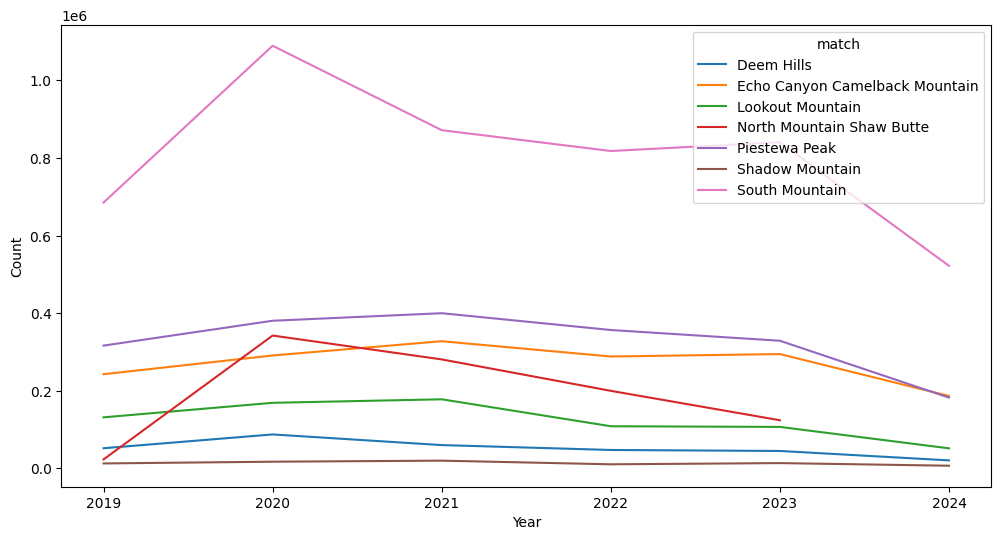

In [95]:
# Trail Activity over the years by Mountain Preserve
plt.figure(figsize=(12, 6))
data = mtn_trails.drop(['Date'], axis=1).groupby(['Year','match']).sum().reset_index()
sns.lineplot(data=data, x='Year', y='Count', hue='match')

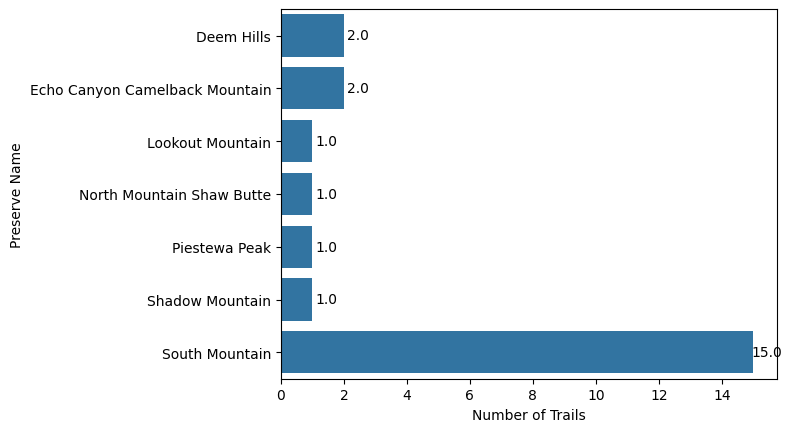

In [93]:
# Number of trails with data for each mountain preserve (with data)

data = mtn_trails.drop(['Date'], axis=1).groupby(['match']).nunique()
ax = sns.barplot(data=data, y='match', x='Site')

ax.set_ylabel('Preserve Name')
ax.set_xlabel('Number of Trails')

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.1f'), 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha = 'center', va = 'center', 
                xytext = (10, 0), 
                textcoords = 'offset points')